In [2]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [4]:
device = torch.device("mps")
device

device(type='mps')

In [8]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("../data/raw/ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [26]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

train_df.to_csv('../data/interim/train.csv')
test_df.to_csv('../data/interim/test.csv')

Rating Distribution


/var/folders/6j/s19nhfjj4pv14vny7nrq8lf00000gn/T/ipykernel_17662/2156695850.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = list(int(distrobution.iloc[i]) for i in range(5))


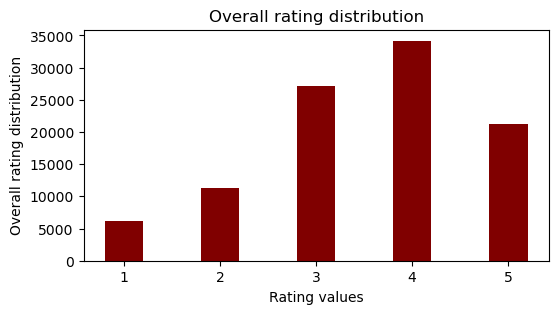

In [25]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
distrobution = pd.DataFrame(df.groupby(['rating'])['rating'].count())

ratings = list(range(1,6))
values = list(int(distrobution.iloc[i]) for i in range(5))

fig = plt.figure(figsize = (6, 3))
 
# creating the bar plot
plt.bar(ratings, values, color ='maroon', 
        width = 0.4)
 
plt.xlabel("Rating values")
plt.ylabel("Overall rating distribution")
plt.title("Overall rating distribution")
plt.show()
fig.savefig('../reports/figures/rating_distribution.png', dpi=fig.dpi)


In [30]:
columns_name=['id','age','gender','ocupation', 'zip']
users_df = pd.read_csv("../data/raw/ml-100k/u.user",sep="|", names=columns_name)
users_df.head()

,id,age,gender,ocupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [51]:
genre_df = pd.read_csv("../data/raw/ml-100k/u.genre", sep='|', names=['genre', 'id'])
genres = {}
for i in range(len(genre_df)):
    genres[i] = genre_df.iloc[i]['genre']
genres

{0: 'unknown',
 1: 'Action',
 2: 'Adventure',
 3: 'Animation',
 4: "Children's",
 5: 'Comedy',
 6: 'Crime',
 7: 'Documentary',
 8: 'Drama',
 9: 'Fantasy',
 10: 'Film-Noir',
 11: 'Horror',
 12: 'Musical',
 13: 'Mystery',
 14: 'Romance',
 15: 'Sci-Fi',
 16: 'Thriller',
 17: 'War',
 18: 'Western'}

In [52]:
columns_name=['id','title','release_date','video_release_date', 'url'] + [*list(genres.values())]
films_df = pd.read_csv("../data/raw/ml-100k/u.item",sep="|", names=columns_name)
films_df.head()

,id,title,release_date,video_release_date,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
# film's genres look not good

genre = []
list_of_genres = []
for i in range(len(films_df)):
    for gen_name in list(genres.values()):
        if int(films_df.iloc[i][gen_name]) == 1:
            genre.append(gen_name)
    list_of_genres.append(genre.copy())

films_df['genre'] = list_of_genres
films_df.head()

,id,title,release_date,video_release_date,url,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,"[Animation, Children's, Comedy, Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller]"
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller, Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller, Action, Comedy, Drama, Crime, Drama, Thriller]"


In [54]:
films_df = films_df.drop(columns=[*list(genres.values())])
films_df.head()

,id,title,release_date,video_release_date,url,genre
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),"[Animation, Children's, Comedy, Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller]"
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller, Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[Animation, Children's, Comedy, Action, Adventure, Thriller, Thriller, Action, Comedy, Drama, Crime, Drama, Thriller]"


In [56]:
mean_rating = []
for film in films_df['id']:
    curr_rate = 0
    c = 0
    for i in range(len(df)):
        if df.iloc[i]['item_id'] == film:
            curr_rate += df.iloc[i]['rating']
            c += 1
    mean_rating.append(curr_rate/c)

mean_rating